In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import shap
from tensorflow.keras.metrics import RootMeanSquaredError
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import svm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from skbio.stats.composition import clr
from skbio.stats import subsample_counts
import shap
from sklearn.metrics import make_scorer, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Input
from keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import RocCurveDisplay, auc

In [3]:
os.chdir("/Volumes/My Passport/data1/ibd/prediction_datasets/3_future_response/")

In [4]:
specificity = make_scorer(recall_score, pos_label=0)
scoring = {'acc': 'accuracy',
          'sensitivity':'recall',
          'specificity':specificity}
result_table = pd.DataFrame(columns=['type','auc','accuracy', 'sensitivity','specificity','fpr','tpr','rsme','hidden_layer','units'])

In [5]:
#Scoring
def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def tpr_score(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return tpr[1]  # Return the true positive rate for the first threshold

def fpr_score(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return fpr[1]  # Return the false positive rate for the first threshold
# def specificity_score(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     return tn / (tn + fp)
def rmse_scorer(y_true, y_pred_proba):
    return np.sqrt(mean_squared_error(y_true, y_pred_proba))

auc_scorer = make_scorer(auc_score, needs_proba=True)
tpr_scorer = make_scorer(tpr_score, needs_proba=True)
fpr_scorer = make_scorer(fpr_score, needs_proba=True)
specificity = make_scorer(recall_score, pos_label=0)
rsme = make_scorer(rmse_scorer, needs_proba=True)
scoring = {
    'acc': 'accuracy',
    'sensitivity': 'recall',
    'specificity': specificity,
    'auc': auc_scorer,
    'tpr': tpr_scorer,
    'fpr': fpr_scorer,
    'rsme': rsme
}

In [7]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
def pointbiserialFilter(X,y):
    corr_list = []
    p_val_list=[]
    X_list=[]
    for i in range(len(X.columns)):
        cor=stats.pointbiserialr(X.iloc[:,i], y)
        corr_list.append(cor[0])
        p_val_list.append(cor[1])
        X_list.append(X.columns[i])
    cor_df=pd.DataFrame({"cor":corr_list,"pval":p_val_list,"name":X_list})
    index=((cor_df.iloc[:,0]>0.1) | (cor_df.iloc[:,0]< -0.1)) & (cor_df.iloc[:,1]<0.05) 
    X_transpose=X.T
    X=X_transpose[index.set_axis(X_transpose.index)].T
    return X,index,cor_df

def create_baseline(hidden_layer=1, units=10,l1_value=0.01, l2_value=0.01, dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(Dense(units, activation='relu',kernel_regularizer=l1_l2(l1=l1_value, l2=l2_value)))
    model.add(Dropout(dropout_rate))
    for i in range(hidden_layer):
        model.add(Dense(units, activation='relu',kernel_regularizer=l1_l2(l1=l1_value, l2=l2_value)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def train_and_save_results(X,y,result_table,hidden_layer,type_):
    max_units=40
    for units in range(2,max_units+1):
        print("Running with neuron units: %s" % str(units))
        estimator = KerasClassifier(build_fn=create_baseline,hidden_layer=hidden_layer,units=units, epochs=150, batch_size=32, verbose=0,metrics=['accuracy',RootMeanSquaredError()])
        kfold = StratifiedKFold(n_splits=10, shuffle=True)
        scores = cross_validate(estimator, X.astype(float), y, cv=kfold,scoring=scoring)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        estimator.fit(X_train,y_train,epochs=150, batch_size=32,verbose=0)
        y_val_pred_prob=estimator.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_test,  y_val_pred_prob)
        auc_score = auc(fpr, tpr)
        rsme=root_mean_squared_error(y_test,y_val_pred_prob)
        result_table = pd.concat([result_table, pd.DataFrame([{'type':type_,
                                                'auc':auc_score,
                                                'accuracy':scores['test_acc'],
                                                'sensitivity':scores['test_sensitivity'],
                                                'specificity':scores['test_specificity'],
                                                'fpr':fpr,
                                                'tpr':tpr,
                                                'rsme':rsme.numpy(),
                                                'hidden_layer':hidden_layer,
                                                'units':units
                                                               
                                         }])], ignore_index=True)
    return result_table

def train_and_save_results_leave_one_group_out(X,y,result_table,hidden_layer,type_,groups):
    logo=LeaveOneGroupOut()
    max_units=40
    for units in range(2,max_units+1):
        print("Running with neuron units: %s" % str(units))
        estimator = KerasClassifier(build_fn=create_baseline,hidden_layer=hidden_layer,units=units, epochs=150, batch_size=32, verbose=0,metrics=['accuracy',RootMeanSquaredError()])
        kfold = StratifiedKFold(n_splits=10, shuffle=True)
        scores = cross_val_score(estimator, X.astype(float), y, cv=logo,scoring=scoring,groups=groups)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        estimator.fit(X_train,y_train,epochs=150, batch_size=32,verbose=0)
        y_val_pred_prob=estimator.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_test,  y_val_pred_prob)
        auc_score = auc(fpr, tpr)
        rsme=root_mean_squared_error(y_test,y_val_pred_prob)
        result_table = pd.concat([result_table, pd.DataFrame([{'type':type_,
                                                'auc':auc_score,
                                                # 'accuracy':scores['test_accuracy'],
                                                # 'sensitivity':scores['test_sensitivity'],
                                                # 'specificity':scores['test_specificity'],
                                                'fpr':fpr,
                                                'tpr':tpr,
                                                'rsme':rsme.numpy(),
                                                'hidden_layer':hidden_layer,
                                                'units':units
                                                               
                                         }])], ignore_index=True)
    return result_table

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def train_and_return_model_logo(estimator,X,y,result_table,groups):
    logo=LeaveOneGroupOut()
    #estimator = KerasClassifier(build_fn=create_baseline,hidden_layer=hidden_layer_,units=units_, epochs=epoch_, batch_size=batch_size_, verbose=0,metrics=['accuracy',RootMeanSquaredError()])
    scores = cross_validate(estimator, X.astype(float), y, cv=logo, scoring=scoring, groups=groups, return_train_score=False)
    result_table = pd.concat([result_table, pd.DataFrame([{'type':estimator.__class__.__name__,
                                            'auc':scores['test_acc'],
                                            'accuracy':scores['test_acc'],
                                            'sensitivity':scores['test_sensitivity'],
                                            'specificity':scores['test_specificity'],
                                            'fpr':scores['test_fpr'],
                                            'tpr':scores['test_tpr'],
                                     }])], ignore_index=True)
    return result_table

def train_and_return_model(estimator,X,y,result_table):
    #estimator = KerasClassifier(build_fn=create_baseline,hidden_layer=hidden_layer_,units=units_, epochs=epoch_, batch_size=batch_size_, verbose=0,metrics=['accuracy',RootMeanSquaredError()])
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    scores = cross_validate(estimator, X.astype(float), y, cv=kfold,scoring=scoring)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    #estimator.fit(X_train,y_train,epochs=epoch_, batch_size=batch_size_,verbose=0)
    #y_val_pred_prob=estimator.predict_proba(X_test)[::,1]
    #fpr, tpr, _ = roc_curve(y_test,  y_val_pred_prob)
    #auc_score = auc(fpr, tpr)
    #rsme=root_mean_squared_error(y_test,y_val_pred_prob)    
    result_table = pd.concat([result_table, pd.DataFrame([{'type':estimator.__class__.__name__,
                                            'auc':scores['test_acc'],
                                            'accuracy':scores['test_acc'],
                                            'sensitivity':scores['test_sensitivity'],
                                            'specificity':scores['test_specificity'],
                                            'fpr':scores['test_fpr'],
                                            'tpr':scores['test_tpr'],
                                     }])], ignore_index=True)
    return result_table


def combine_meta_with_data(X):
    meta=pd.read_csv("metadata.csv",sep=",",header=0)
    columns=["sample","current.disease","current.calprotectin_range.V1","current.calprotectin_range.V2",
             "current.calprotectin_range.V3","current.calprotectin_range.V4","current.severity",
             "current.age","gender","current.antibiotics","Anti-TNFa","5ASA","AZA","Steroids"]
    meta=meta.loc[:,columns]
    mergedX=X.merge(meta,how="inner",on="sample")
    print(mergedX.columns)
    mergedX["current.disease"]=LabelEncoder().fit_transform(mergedX["current.disease"])
    mergedX["current.calprotectin_range.V1"]=LabelEncoder().fit_transform(mergedX["current.calprotectin_range.V1"])
    mergedX["current.calprotectin_range.V2"]=LabelEncoder().fit_transform(mergedX["current.calprotectin_range.V2"])
    mergedX["current.calprotectin_range.V3"]=LabelEncoder().fit_transform(mergedX["current.calprotectin_range.V3"])
    mergedX["current.calprotectin_range.V4"]=LabelEncoder().fit_transform(mergedX["current.calprotectin_range.V4"])
    mergedX["current.severity"]=LabelEncoder().fit_transform(mergedX["current.severity"])
    mergedX["current.age"]=LabelEncoder().fit_transform(mergedX["current.age"])
    mergedX["gender"]=LabelEncoder().fit_transform(mergedX["gender"])
    mergedX["current.antibiotics"]=LabelEncoder().fit_transform(mergedX["current.antibiotics"])
    mergedX["Anti-TNFa"]=LabelEncoder().fit_transform(mergedX["Anti-TNFa"])
    mergedX["5ASA"]=LabelEncoder().fit_transform(mergedX["5ASA"])
    mergedX["AZA"]=LabelEncoder().fit_transform(mergedX["AZA"])
    mergedX["Steroids"]=LabelEncoder().fit_transform(mergedX["Steroids"])
    X=mergedX
    X=X.drop(columns=['current.calprotectin_range.V2', 'current.calprotectin_range.V1','current.calprotectin_range.V4'])
    return X





#### import metadata

In [9]:
os.chdir("/Volumes/My Passport/data1/ibd/prediction_datasets/3_future_response/")
dataframe = pd.read_csv("future_responder.sample_class_for_studywise_crossvalidation.tsv",sep="\t", header=0)
dataset = dataframe.values
y=dataframe["future.response"]
y = LabelEncoder().fit_transform(y)
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

#### import batch correct ASV counts

In [10]:
X=pd.read_csv("./batch_effect.GLASV_otutab.ACHIKNS_ver.after_MMUPHin_disease_covar.asv_read_count.tsv",sep="\t",header=0,index_col=0)
X=np.log(X+1)
X=X.loc[dataframe["sample"],]
X,index,cor_df=pointbiserialFilter(X,y)
X=combine_meta_with_data(X)
dataframe=dataframe.set_index("sample")
X=X.set_index("sample")
groups=dataframe.loc[X.index,"study"]
groups=LabelEncoder().fit_transform(groups)

X=X.to_numpy()

Index(['sample', 'AlipourM_2016__Zotu1065', 'AlipourM_2016__Zotu1068',
       'AlipourM_2016__Zotu1072', 'AlipourM_2016__Zotu1087',
       'AlipourM_2016__Zotu112', 'AlipourM_2016__Zotu1124',
       'AlipourM_2016__Zotu113', 'AlipourM_2016__Zotu1143',
       'AlipourM_2016__Zotu1158',
       ...
       'current.calprotectin_range.V3', 'current.calprotectin_range.V4',
       'current.severity', 'current.age', 'gender', 'current.antibiotics',
       'Anti-TNFa', '5ASA', 'AZA', 'Steroids'],
      dtype='object', length=709)


In [12]:
# best parameters for DNN
hidden_layer_=2
units_=99
epochs_=50
batch_size_=128
l1_=0.001
l2_=0.002
dropout_=0.3
n_splits=10

In [13]:
models={"DNN": KerasClassifier(build_fn=create_baseline,hidden_layer=hidden_layer_,units=units_, l1_value=l1_, l2_value=l2_, dropout_rate=dropout_,epochs=epochs_,batch_size=batch_size_, verbose=0,metrics=['accuracy']),
        "LogisticRegression":LogisticRegression(C=0.1),
        "KNeighborsClassifier":KNeighborsClassifier(weights="distance",p=1,n_neighbors=8),
        "DecisionTreeClassifier":DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=10,max_depth=15),
        "RandomForestClassifier":RandomForestClassifier(n_estimators=400,min_samples_split=4,min_samples_leaf=2,max_features="sqrt",max_depth=18),
        "GradientBoostingClassifier":GradientBoostingClassifier(subsample=0.5,n_estimators=300,max_depth=19,learning_rate=0.2),
        "SVC":svm.SVC(probability=True,kernel="linear",gamma="scale",C=0.1)
       }

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
auc_scores = {}
for key in models.keys():
    estimator=models[key]
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold, (train, test) in enumerate(cv.split(X, y)):
        estimator.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            estimator,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            plot_chance_level=(fold == n_splits - 1)
        )
        plt.close()
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_scores[key]=mean_auc
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        label=r"%s (AUC = %0.2f $\pm$ %0.2f)" % (key,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
ax.plot([0,1], [0,1], color='orange', linestyle='--')
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()


In [39]:
del auc_scores["DecisionTreeClassifier"]
del auc_scores["KNeighborsClassifier"]
del auc_scores["RandomForestClassifier"]
del auc_scores["GradientBoostingClassifier"]

In [40]:
# Three models with >85 AUC for Ensemble model
auc_scores

{'DNN': 0.8825028945582305,
 'LogisticRegression': 0.877480336966503,
 'SVC': 0.8620553359683795}

In [12]:
models_final={"Ensemble Model":VotingClassifier(estimators=[
    ('dnn', models["DNN"]),
    ('log_reg', models["LogisticRegression"]),
    #('rf', models["RandomForestClassifier"]),
    #('gb', models["GradientBoostingClassifier"]),
    ('svc', models["SVC"])
],
                                                #weights=[weights[name] for name in auc_scores.keys()], 
                                                weights=[2,3,1],
                                                voting='soft'),
        "DNN": KerasClassifier(build_fn=create_baseline,hidden_layer=hidden_layer_,units=units_, l1_value=l1_, l2_value=l2_, dropout_rate=dropout_,epochs=epochs_,batch_size=batch_size_, verbose=0,metrics=['accuracy']),
        "LogisticRegression":LogisticRegression(C=0.1),
        "KNeighborsClassifier":KNeighborsClassifier(weights="distance",p=1,n_neighbors=8),
        "DecisionTreeClassifier":DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=10,max_depth=15),
        "RandomForestClassifier":RandomForestClassifier(n_estimators=400,min_samples_split=4,min_samples_leaf=2,max_features="sqrt",max_depth=18),
        "GradientBoostingClassifier":GradientBoostingClassifier(subsample=0.5,n_estimators=300,max_depth=19,learning_rate=0.2),
        "SVC":svm.SVC(probability=True,kernel="linear",gamma="scale",C=0.1)
       }

#models["Ensemble Model"]=

2024-08-11 21:27:12.636560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:14.906027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:15.272725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2024-08-11 21:27:18.023781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:18.382778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2024-08-11 21:27:20.587784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:20.929057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:23.182099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:23.517284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:25.794707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:26.137457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 21:27:28.423493: I tensorflow/core/grappler/optimizers/cust

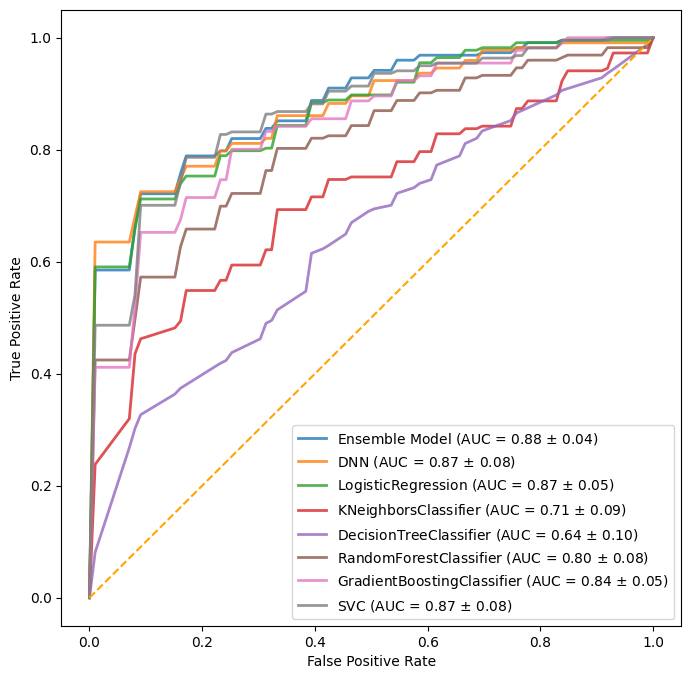

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
auc_scores = {}
for key in models_final.keys():
    estimator=models_final[key]
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold, (train, test) in enumerate(cv.split(X, y)):
        estimator.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            estimator,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            plot_chance_level=(fold == n_splits - 1)
        )
        plt.close()
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_scores[key]=mean_auc
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        label=r"%s (AUC = %0.2f $\pm$ %0.2f)" % (key,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
ax.plot([0,1], [0,1], color='orange', linestyle='--')
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

In [14]:
fig.savefig('ROC_curve_ver4.png', dpi=300)

In [15]:
dataframe=dataframe.reset_index()
X=pd.read_csv("./batch_effect.GLASV_otutab.ACHIKNS_ver.after_MMUPHin_disease_covar.asv_read_count.tsv",sep="\t",header=0,index_col=0)
X=np.log(X+1)
X=X.loc[dataframe["sample"],]
X,index,cor_df=pointbiserialFilter(X,y)
X=combine_meta_with_data(X)
X=X.set_index("sample")

Index(['sample', 'AlipourM_2016__Zotu1065', 'AlipourM_2016__Zotu1068',
       'AlipourM_2016__Zotu1072', 'AlipourM_2016__Zotu1087',
       'AlipourM_2016__Zotu112', 'AlipourM_2016__Zotu1124',
       'AlipourM_2016__Zotu113', 'AlipourM_2016__Zotu1143',
       'AlipourM_2016__Zotu1158',
       ...
       'current.calprotectin_range.V3', 'current.calprotectin_range.V4',
       'current.severity', 'current.age', 'gender', 'current.antibiotics',
       'Anti-TNFa', '5ASA', 'AZA', 'Steroids'],
      dtype='object', length=709)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [24]:
models_final.keys()

dict_keys(['Ensemble Model', 'DNN', 'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'SVC'])

In [29]:
shap_values_list = []
for key in ['DNN','LogisticRegression', 'SVC']:
    model = models_final[key]
    model.fit(X_train,y_train)
    #ensemble.fit(X_train, y_train)
    explainer = shap.KernelExplainer(model.predict, X_train)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values)

2024-08-12 09:39:39.287352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 09:39:40.716167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
  2%|▊                                          | 2/105 [00:35<30:26, 17.74s/it]

100%|███████████████████████████████████████| 105/105 [1:12:28<00:00, 41.42s/it]


In [28]:
with open(r"shap_values_list.pickle", "wb") as output_file:
    pickle.dump(shap_values_list, output_file)

In [30]:
weights=[2,3,1]

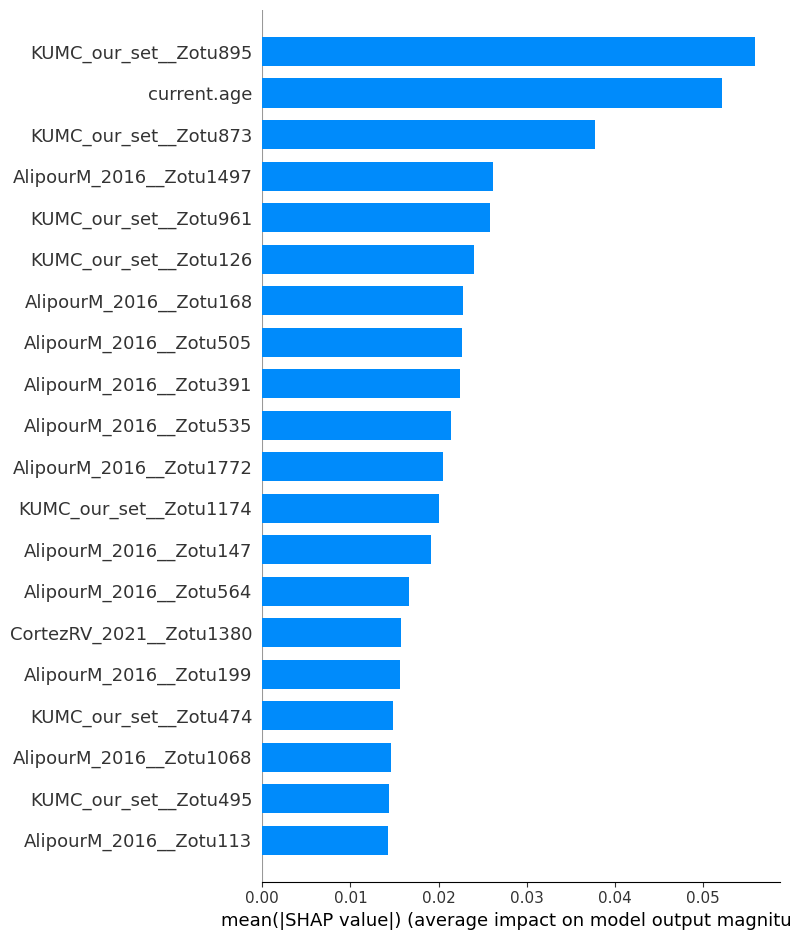

In [31]:
avg_shap_values = np.average(shap_values_list, axis=0, weights=weights)
shap.summary_plot(avg_shap_values, X_test,plot_type="bar")

In [32]:
shap_df = pd.DataFrame(avg_shap_values, columns=X_test.columns)
shap_df.abs().mean().to_csv("./shap_mean_batch_new.csv")
shap_df.to_csv("./shap_batch_new.csv")


In [35]:
shap_mean=shap_df.abs().mean().to_frame().reset_index()

In [36]:
shap_mean.columns=["Feature","Mean_SHAP_value"]

In [38]:
shap_mean.to_csv("./shap_mean_batch_new.csv")

In [242]:
shap_mean=shap_mean.sort_values(by="Mean_SHAP_value",ascending=False)[0:20]

In [33]:
file_path = 'batch_effect.GLASV.cor.append_taxonomy.xlsx'
data = pd.read_excel(file_path)


In [168]:
print(models["LogisticRegression"].__class__.__name__)

LogisticRegression


In [37]:
result_table=pd.DataFrame(columns=['type','auc','accuracy', 'sensitivity','specificity','fpr','tpr'])
result_table=train_and_return_model(models_final["Ensemble Model"],X,y,result_table)
result_table=train_and_return_model(models_final["DNN"],X,y,result_table)
result_table=train_and_return_model(models_final["LogisticRegression"],X,y,result_table)
result_table=train_and_return_model(models_final["KNeighborsClassifier"],X,y,result_table)
result_table=train_and_return_model(models_final["DecisionTreeClassifier"],X,y,result_table)
result_table=train_and_return_model(models_final["RandomForestClassifier"],X,y,result_table)
result_table=train_and_return_model(models_final["GradientBoostingClassifier"],X,y,result_table)
result_table=train_and_return_model(models_final["SVC"],X,y,result_table)


2024-08-11 22:13:41.069234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 22:13:46.519645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 22:13:46.958404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 22:13:53.718403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 22:13:54.147094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 22:13:59.043240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-11 22:13:59.419618: I tensorflow/core/grappler/optimizers/cust

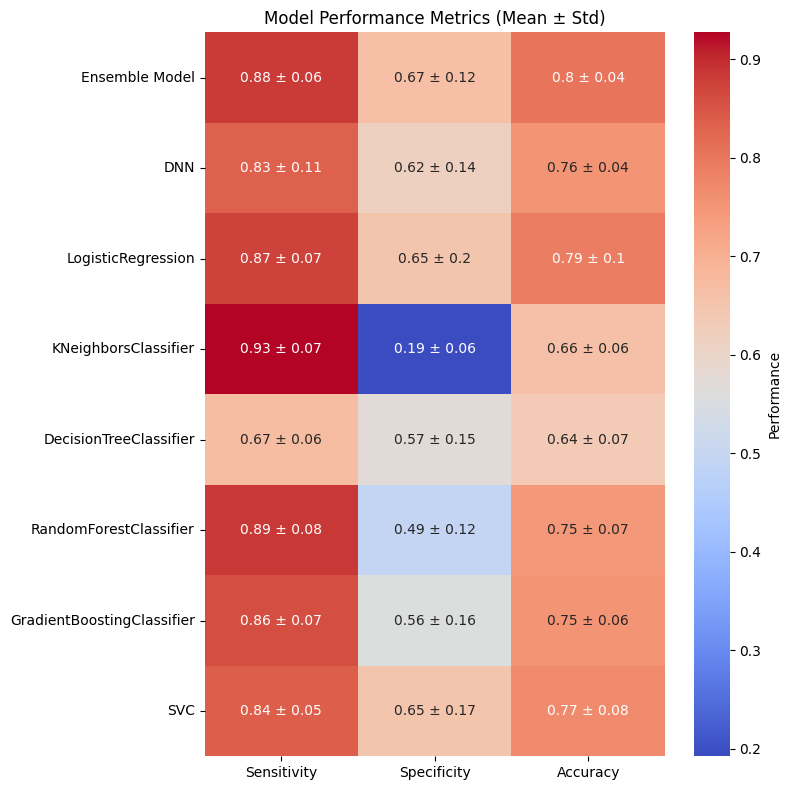

In [39]:
result_table.loc[0,"type"]="Ensemble Model"
result_table.loc[1,"type"]="DNN"
# Calculate mean and standard deviation values for each metric per model
df=result_table
mean_sensitivity = df.set_index('type')['sensitivity'].apply(np.mean)
std_sensitivity = df.set_index('type')['sensitivity'].apply(np.std)
mean_specificity = df.set_index('type')['specificity'].apply(np.mean)
std_specificity = df.set_index('type')['specificity'].apply(np.std)
mean_accuracy = df.set_index('type')['accuracy'].apply(np.mean)
std_accuracy = df.set_index('type')['accuracy'].apply(np.std)

# Combine into a single DataFrame
metrics_mean = pd.DataFrame({
    'Sensitivity': mean_sensitivity,
    'Specificity': mean_specificity,
    'Accuracy': mean_accuracy
}).reset_index()

metrics_std = pd.DataFrame({
    'Sensitivity': std_sensitivity,
    'Specificity': std_specificity,
    'Accuracy': std_accuracy
}).reset_index()

# Combine mean and std for annotations
annotations = metrics_mean.set_index('type').round(2).astype(str) + " ± " + metrics_std.set_index('type').round(2).astype(str)

# Plot heatmap
plt.figure(figsize=(8, 8))
ax = sns.heatmap(metrics_mean.set_index('type'), annot=annotations, fmt='', cmap='coolwarm', cbar_kws={'label': 'Performance'})
plt.title('Model Performance Metrics (Mean ± Std)')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig("heatmap_ver2.png",dpi=300)

<Figure size 640x480 with 0 Axes>

In [258]:
import dill

2024-08-12 15:54:29.141754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 15:54:31.797247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 15:54:32.220280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 15:54:35.605149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 15:54:35.858889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 15:54:39.557796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 15:54:39.844059: I tensorflow/core/grappler/optimizers/cust

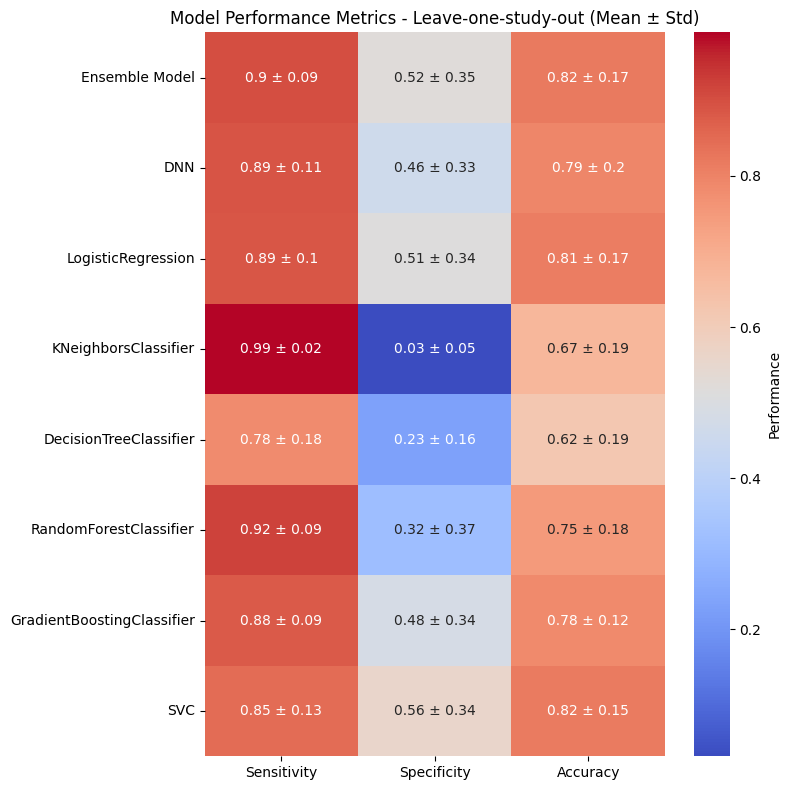

In [55]:
result_table=pd.DataFrame(columns=['type','auc','accuracy', 'sensitivity','specificity','fpr','tpr'])
result_table=train_and_return_model_logo(models_final["Ensemble Model"],X,y,result_table,groups)
result_table=train_and_return_model_logo(models_final["DNN"],X,y,result_table,groups)
result_table=train_and_return_model_logo(models_final["LogisticRegression"],X,y,result_table,groups)
result_table=train_and_return_model_logo(models_final["KNeighborsClassifier"],X,y,result_table,groups)
result_table=train_and_return_model_logo(models_final["DecisionTreeClassifier"],X,y,result_table,groups)
result_table=train_and_return_model_logo(models_final["RandomForestClassifier"],X,y,result_table,groups)
result_table=train_and_return_model_logo(models_final["GradientBoostingClassifier"],X,y,result_table,groups)
result_table=train_and_return_model_logo(models_final["SVC"],X,y,result_table,groups)
result_table.loc[0,"type"]="Ensemble Model"
result_table.loc[1,"type"]="DNN"

# Calculate mean and standard deviation values for each metric per model
df=result_table
mean_sensitivity = df.set_index('type')['sensitivity'].apply(np.mean)
std_sensitivity = df.set_index('type')['sensitivity'].apply(np.std)
mean_specificity = df.set_index('type')['specificity'].apply(np.mean)
std_specificity = df.set_index('type')['specificity'].apply(np.std)
mean_accuracy = df.set_index('type')['accuracy'].apply(np.mean)
std_accuracy = df.set_index('type')['accuracy'].apply(np.std)

# Combine into a single DataFrame
metrics_mean = pd.DataFrame({
    'Sensitivity': mean_sensitivity,
    'Specificity': mean_specificity,
    'Accuracy': mean_accuracy
}).reset_index()

metrics_std = pd.DataFrame({
    'Sensitivity': std_sensitivity,
    'Specificity': std_specificity,
    'Accuracy': std_accuracy
}).reset_index()

# Combine mean and std for annotations
annotations = metrics_mean.set_index('type').round(2).astype(str) + " ± " + metrics_std.set_index('type').round(2).astype(str)

# Plot heatmap
plt.figure(figsize=(8, 8))
ax = sns.heatmap(metrics_mean.set_index('type'), annot=annotations, fmt='', cmap='coolwarm', cbar_kws={'label': 'Performance'})
plt.title('Model Performance Metrics - Leave-one-study-out (Mean ± Std)')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig("heatmap_logo_ver2.png",dpi=300)

In [298]:
set(dataframe.loc[:,"study"])

{'HurychJ_2023',
 'IjazUZ_2017.metadata.tsv',
 'KUMC_our_set.metadata.tsv',
 'NusbaumDJ_2018.metadata.tsv',
 'SchirmerM_2018.metadata.tsv'}

Ensemble Model
0


2024-08-13 15:59:20.191240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:22.743778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Ensemble Model
1


2024-08-13 15:59:23.115363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:25.651069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Ensemble Model
2


2024-08-13 15:59:26.020755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:28.562162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Ensemble Model
3


2024-08-13 15:59:28.912245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:31.480796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Ensemble Model
4


2024-08-13 15:59:31.875491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:34.779044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DNN
0


2024-08-13 15:59:35.157397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:37.407712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DNN
1


2024-08-13 15:59:37.612217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:40.185313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DNN
2


2024-08-13 15:59:40.403946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:42.972260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:43.169092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DNN
3


2024-08-13 15:59:45.817434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


DNN
4


2024-08-13 15:59:46.021539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-13 15:59:48.629336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


LogisticRegression
0
LogisticRegression
1
LogisticRegression
2
LogisticRegression
3
LogisticRegression
4
KNeighborsClassifier
0
KNeighborsClassifier
1
KNeighborsClassifier
2
KNeighborsClassifier
3
KNeighborsClassifier
4
DecisionTreeClassifier
0
DecisionTreeClassifier
1
DecisionTreeClassifier
2
DecisionTreeClassifier
3
DecisionTreeClassifier
4
RandomForestClassifier
0
RandomForestClassifier
1
RandomForestClassifier
2
RandomForestClassifier
3
RandomForestClassifier
4
GradientBoostingClassifier
0
GradientBoostingClassifier
1
GradientBoostingClassifier
2
GradientBoostingClassifier
3
GradientBoostingClassifier
4
SVC
0
SVC
1
SVC
2
SVC
3
SVC
4


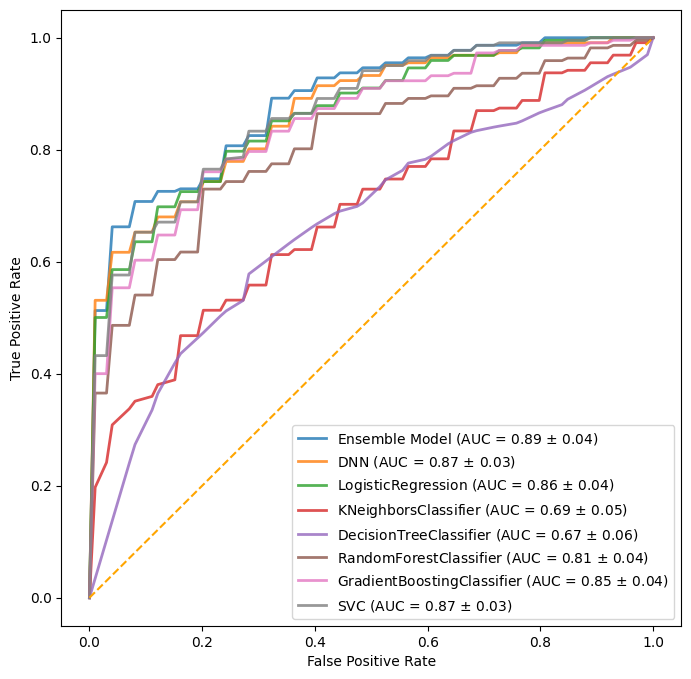

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
auc_scores = {}
for key in models_final.keys():
    estimator=models_final[key]
    cv = StratifiedKFold(n_splits=len(set(groups)), shuffle=True)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold, (train, test) in enumerate(cv.split(X, y, groups)):
        print(key)
        print(fold)
        estimator.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            estimator,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            plot_chance_level=(fold == n_splits - 1)
        )
        plt.close()
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    auc_scores[key]=mean_auc
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        label=r"%s (AUC = %0.2f $\pm$ %0.2f)" % (key,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
ax.plot([0,1], [0,1], color='orange', linestyle='--')
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

In [16]:
fig.savefig('ROC_curve_logo_ver2.png', dpi=300)

In [132]:
final_model = create_baseline(hidden_layer=4, units=39)
final_model.fit(X, y, epochs=150, batch_size=32, verbose=0)

In [133]:
final_model.save('final_model.h5')